# **Final Project**

Gillian Flynn's novels:
- *Sharp Objects* (2006)
- *Dark Places* (2009)
- *Gone Girl* (2012)

In [1]:
# project imports
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import Counter
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# load spacy english language model
ner = spacy.load("en_core_web_sm")

This project leverages code from the existing project detailed in [Thu Vu data analytics](https://www.youtube.com/watch?v=fAHkJ_Dhr50)' video tutorial on creating a character network for *The Witcher*.

## *Gone Girl*

In order to develop character networks that can help us understand *Gone Girl* better, we will be processing the three parts of the novel - Boy Loses Girl, Boy Meets Girl, Boy Gets Girl Back - separately.

### Boy Loses Girl

#### Extracting Character Entities Using Name Entity Recognition

To begin the process of breaking down the novel in order to generate useful data for character analysis, we will first run the text through spaCy's Name Entity Recognition model.

In [2]:
# load the book and run name entity recognition on it
gg1_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part1.txt")
gg1_text = open(gg1_book, encoding="utf8").read()
gg1_doc = ner(gg1_text)

In [3]:
# preview of the ner results
displacy.render(gg1_doc[0:766], style="ent", jupyter=True)

Because we are primarily interested in the character entities for our eventual construction of character networks, we want to run through the text to extract co-occurance data. This will require us to filter out character entities on a sentence-level granularity.

Before we do this, however, we will extract a character list using BookNLP's model for extracting character data. This will help us in the filtering process described above.

In [4]:
# functions for extracting novel information
# note: leveraged from the BookNLP documentation
def proc(filename):
    with open(filename) as file:
        data=json.load(file)
    return data

def get_counter_from_dependency_list(dep_list):
    counter=Counter()
    for token in dep_list:
        term=token["w"]
        tokenGlobalIndex=token["i"]
        counter[term]+=1
    return counter

# function for extracting character information
# note: leveraged from the BookNLP documentation
def create_character_data(data, printTop):
    character_data = {}
    for character in data["characters"]:

        agentList=character["agent"]
        patientList=character["patient"]
        possList=character["poss"]
        modList=character["mod"]

        character_id=character["id"]
        count=character["count"]

        referential_gender_distribution=referential_gender_prediction="unknown"

        if character["g"] is not None and character["g"] != "unknown":
            referential_gender_distribution=character["g"]["inference"]
            referential_gender=character["g"]["argmax"]

        mentions=character["mentions"]
        proper_mentions=mentions["proper"]
        max_proper_mention=""

        # create some empty lists we can append to
        poss_items = []
        agent_items = []
        patient_items = []
        mod_items = []
        
        # just print out information about named characters
        if len(mentions["proper"]) > 0:
            max_proper_mention=mentions["proper"][0]["n"]
            for k, v in get_counter_from_dependency_list(possList).most_common(printTop):
                poss_items.append((v,k))
            for k, v in get_counter_from_dependency_list(agentList).most_common(printTop):
                agent_items.append((v,k))
            for k, v in get_counter_from_dependency_list(patientList).most_common(printTop):
                patient_items.append((v,k))
            for k, v in get_counter_from_dependency_list(modList).most_common(printTop):
                mod_items.append((v,k))
        
            # print(character_id, count, max_proper_mention, referential_gender)
            character_data[character_id] = {"name": max_proper_mention,
                                            "id": character_id,
                                            "timesMentioned": count,
                                            "gender": referential_gender,
                                            "possList": poss_items,
                                            "agentList": agent_items,
                                            "patientList": patient_items,
                                            "modList": mod_items}
    
    return character_data

In [5]:
# utilize above functions to produce a list of characters in Gone Girl
gone_girl_data = proc(r"C:\Users\tracypaige\LTCS180\bookNLP_gillian_flynn\gone_girl\gone_girl.book")
gone_girl_character_data = create_character_data(gone_girl_data, 50)
gone_girl_characters_df = pd.DataFrame(gone_girl_character_data).T.reset_index(drop=True)[['name']]
# lowercase the names for uniformity for future processing
gone_girl_characters_df['name'] = gone_girl_characters_df['name'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [6]:
# remove rows with duplicates
gone_girl_characters_df = gone_girl_characters_df.drop_duplicates()
# take a look at the character list
pd.set_option('display.max_rows', None)
gone_girl_characters_df

,name
0,amy
1,nick
2,go
3,desi
4,boney
5,andie
6,tanner
7,rand
8,gilpin
9,greta


Although most of the characters seem to have processed correctly, we will manually go through them to ensure that the list is accurate. This is important because we want our character network to be as precise as possible, as the accuracy of the character nodes is contingent on the accuracy of the character list.

In [7]:
# manually remove inaccurate entries
gone_girl_characters_df = gone_girl_characters_df.drop([25, 27, 28, 39, 41, 44, 47, 50, 53, 55,
                                                        56, 60, 61, 64, 69, 75, 76, 77, 79, 80,
                                                        81, 82, 83, 84, 85, 86, 87, 88, 91, 93,
                                                        94, 97, 99, 101, 102, 103, 105, 106, 107, 110,
                                                        113, 114, 116, 118, 119, 120, 121, 123, 125, 126,
                                                        127, 129, 130, 132, 133, 134, 136, 137, 139, 140, 141])

# reset index and look at updated character list
gone_girl_characters_df = gone_girl_characters_df.reset_index()
gone_girl_characters_df.head(20)

,index,name
0,0,amy
1,1,nick
2,2,go
3,3,desi
4,4,boney
5,5,andie
6,6,tanner
7,7,rand
8,8,gilpin
9,9,greta


Now, we can run through the text and extract the character entities by comparing the results of the NER model against the names in the character list we've just generated.

In [8]:
gg1_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg1_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg1_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg1_char_entity_df = pd.DataFrame(gg1_char_entity_df)

# remove sentences without character entities
gg1_char_entity_df = gg1_char_entity_df[gg1_char_entity_df['char_entities'].map(len) > 0]

In [9]:
# let's take a look at the dataframe so far
gg1_char_entity_df.head(20)

,sentence,char_entities
1,"(Tony, Kushner, ,, THE, ILLUSION, \n\n\n\n\n\n...",[nick]
13,"(What, are, you, thinking, ,, Amy, ?)",[amy]
40,"(It, had, been, a, compromise, :, Amy, demande...",[amy]
42,"(It, was, a, compromise, ,, but, Amy, did, n’t...",[amy]
43,"(To, Amy, ,, it, was, a, punishing, whim, on, ...",[amy]
47,"(Amy, ,, usually, ., \n\n, Do, not, blame, me,...","[amy, amy]"
62,"(Three, weeks, after, I, got, cut, loose, ,, A...",[amy]
63,"((, Now, I, can, feel, Amy, looking, over, my,...",[amy]
65,"(Just, like, Nick, ,, she, would, say, .)",[nick]
66,"(It, was, a, refrain, of, hers, :, Just, like,...",[nick]


#### Character Network

Now that we have the data for character entities per sentence, we can construct the co-occurence dataframe to use for constructing the character network. We will be examining the co-occurence within every five sentences in the text, and will denote detected relationships with a source and target.

In [10]:
def create_char_relationships(char_entity_df):
    relationships = []

    # loop through the sentence window (3 sentences)
    for i in range(char_entity_df.index[-1]):
        end_i = min(i+3, char_entity_df.index[-1])
        char_list = sum((char_entity_df.loc[i: end_i].char_entities), [])

        # remove duplicate characters so that we don't produce relationships between the same character
        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        # if there is more than character in the window (don't consider relationships between the same character)
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
    # return the relationship list
    return relationships

In [11]:
# create a relationship dataframe and print preview of results
gg1_relationship_df = pd.DataFrame(create_char_relationships(gg1_char_entity_df))

# sort the cases with a->b and b->a
gg1_relationship_df = pd.DataFrame(np.sort(gg1_relationship_df.values, axis = 1), columns = gg1_relationship_df.columns)

# assign values based on number of relationships
gg1_relationship_df["value"] = 1
gg1_relationship_df = gg1_relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [12]:
# take a look at the character relationship dataframe
gg1_relationship_df.head(20)

,source,target,value
0,amy,nick,128
1,alice,amy,4
2,amy,carl,17
3,amy,bleecker,9
4,bleecker,carl,3
5,amy,marybeth,54
6,riordan,velásquez,10
7,boney,velásquez,3
8,gilpin,riordan,3
9,amy,boney,112


Now that we have this dataframe, we can construct the character network.

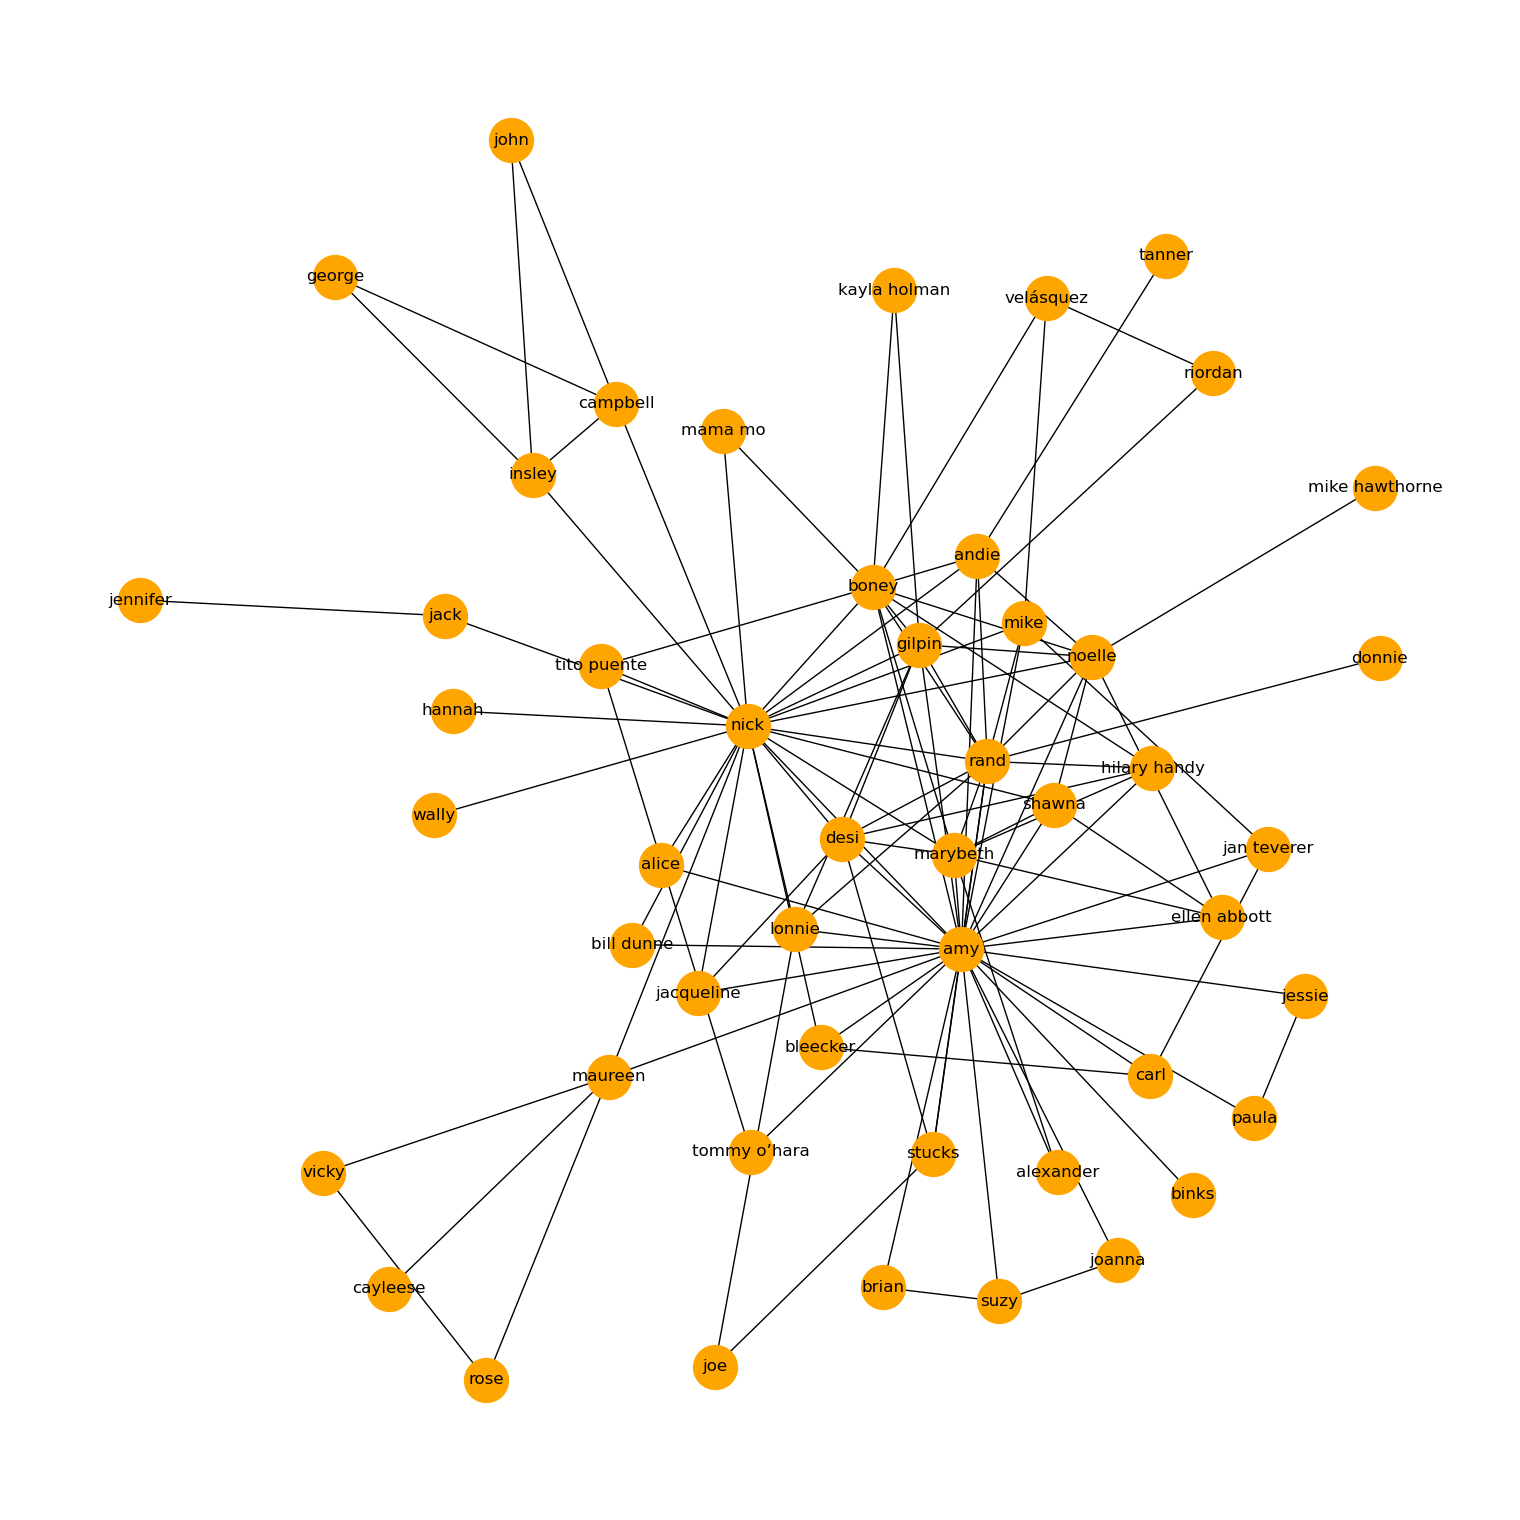

In [13]:
# create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(gg1_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='orange', node_size=1000, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()